Note: this notebook is set up to run with the env.yml containing the name 'polaris_datasets'

## Background
ADME@NCATS is a resource developed by NCATS to host in silico prediction models for various ADME (Absorption, Distribution, Metabolism and Excretion) properties. The resource serves as an important tool for the drug discovery community with potential uses in compound optimization and prioritization. The models were retrospectively validated on a subset of marketed drugs which resulted in very good accuracies.

Data that were used for developing the models are made publicly accessible by depositing them into PubChem database. In some instances, when complete data cannot be made public, a subset of the data are deposited into PubChem. Links to the PubChem assays can be found in the individual model pages. The users are highly encouraged to use these data for development and validation of QSAR models.

## Assay Information
Cytochrome P450 (CYP) enzymes are membrane-bound hemeproteins that play a key role in metabolism of drugs and xenobiotics. Assaying the effect of chemicals on CYP isozymes is useful to minimize the adverse drug reactions and toxicities in drug development process. Chemical compounds were tested for their effect on CYP enzyme activities by using P450-Glo (TM) screening systems (Promega Corporation, Madison, WI). These systems provide a luminescent method containing proluciferin substrates and are converted to luciferin products by CYP isozymes. The luciferin products formed are detected with a luciferin detection reagent, and the amount of light produced is proportional to CYP activity. P450-Glo (TM) CYP2D6 screening system (Catalog. No. V9890) was used to detect the compounds that interfere in CYP2D6 activity. The positive control compound used for CYP2D6 assay is quinidine (Sigma-Aldrich, St. Louis, MO).

## Description of readout:
- **PUBCHEM_ACTIVITY_OUTCOME**: Corresponds to PUBCHEM_ACTIVITY_SCORE. For all inactive compounds, PUBCHEM_ACTIVITY_SCORE is 0. For all active compounds, a score range was given for each curve class type given above. Active antagonist compounds have PUBCHEM_ACTIVITY_SCORE between 40 and 100. Inconclusive compounds had PUBCHEM_ACTIVITY_SCORE between 1 and 39, and were removed in processing. 
- **PUBCHEM_ACTIVITY_SCORE**: Average of 5 experimental replicates. Fit_LogAC50 was used for determining relative score and was scaled to each curve class' score range.

## Data resource

**Raw data**: 
- CYP2D6: https://pubchem.ncbi.nlm.nih.gov/bioassay/1645840
- CYP3A4: https://pubchem.ncbi.nlm.nih.gov/bioassay/1645841
- CYP2C9: https://pubchem.ncbi.nlm.nih.gov/bioassay/1645842

In [1]:
import datamol as dm

from polaris import (
    curation,
    load_dataset,
)
from polaris.curation.viz_utils import (
    visualize_distribution,
    verify_stereoisomers,
    check_undefined_stereocenters,
)
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.utils.types import HubOwner, License
from polaris.hub.client import PolarisHubClient

import tempfile

import pandas as pd
import numpy as np
import utils
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

All datasets were downloaded directly from Pubchem on 2024-03-21 by following the PubChem Bioassay links on https://opendata.ncats.nih.gov/adme/data.

In [3]:
aids = ['AID_1645840', 'AID_1645841', 'AID_1645842']
names = ['CYP2D6', 'CYP3A4', 'CYP2C9']
sources = ['https://pubchem.ncbi.nlm.nih.gov/bioassay/1645840', 'https://pubchem.ncbi.nlm.nih.gov/bioassay/1645841', 'https://pubchem.ncbi.nlm.nih.gov/bioassay/1645842']

datasets = []

# Looking at the files previously (not shown) indicates metadata rows are 0-4
meta_start = 0 # Start row index
meta_end = 5 # End row index + 1

for i in range(len(aids)):
    # Load the dataset
    data = pd.read_parquet(f'gs://polaris-public/data/raw/ADME_NCATS/{aids[i]}_raw.parquet')
    # Remove the metadata rows
    data = data.drop(labels=list(range(meta_start, meta_end)), axis=0).reset_index(drop=True)
    print(f'{names[i]} initial dataset size: {len(data)}')
    # Rename the smiles column
    data.rename(columns = {'PUBCHEM_EXT_DATASOURCE_SMILES' : 'SMILES'}, inplace = True)
    # Remap the outcome to binary
    data['PUBCHEM_ACTIVITY_OUTCOME'] = data['PUBCHEM_ACTIVITY_OUTCOME'].map({'Active':1.0, 'Inactive':0.0}) # Inconclusive compounds will be converted to nan and removed
    # Define data column names
    endpoints = [
        'PUBCHEM_ACTIVITY_OUTCOME',
        'PUBCHEM_ACTIVITY_SCORE',
    ]
    data_cols = endpoints
    mol_col = 'SMILES'

    # Narrow the dataframe to just the data_cols and mol_col
    data=data[['SMILES', 'PUBCHEM_ACTIVITY_OUTCOME', 'PUBCHEM_ACTIVITY_SCORE']]
    # Drop any nans
    data.dropna(axis=0, ignore_index=True, inplace = True)

    print(f'{names[i]} data before curation, after dropping nans: {len(data)}')

    # Curate, dropping duplicates if they exist
    curator = curation.MolecularCurator(
        data=data,
        data_cols=data_cols,
        mol_col=mol_col,
        mask_stereo_undefined_mols=True,
        keep_all_rows = False
    )
    data_curated = curator()
    print(f'{names[i]} data after curation: {len(data_curated)}')

    # Remove any cases where the curator combined two smiles (averaged the pubchem activity outcome)
    data_curated = data_curated.drop(index = data_curated[data_curated['PUBCHEM_ACTIVITY_OUTCOME'] == 0.5].index).reset_index(drop=True)

    # Store the curated dataset in the list
    datasets.append(data_curated)

CYP2D6 initial dataset size: 5242
CYP2D6 data before curation, after dropping nans: 4276
CYP2D6 data after curation: 4114
CYP3A4 initial dataset size: 5242
CYP3A4 data before curation, after dropping nans: 4346
CYP3A4 data after curation: 4203
CYP2C9 initial dataset size: 5242
CYP2C9 data before curation, after dropping nans: 4461
CYP2C9 data after curation: 4298


### Asides: sanity checks ###

The three ADME@NCATS datasets are listed on the [website](https://opendata.ncats.nih.gov/adme/data) as having the same number of molecules (5094). After removing NaNs and duplicates they have rather less than that, and each dataset has a different number of samples (suggesting that they have different molecules). We should verify this 

In [4]:
# Confirmation that even though the datasets are listed as being of the same size on the ADME@NCATS website, they actually contain different molecules
s0 = list(datasets[0].SMILES)
s1 = list(datasets[1].SMILES)
s2 = list(datasets[2].SMILES)
print(len(s0), len(s1), len(s2))

data_sets = [set(s0), set(s1), set(s2)]

for i in range(len(data_sets)):
    for j in range(len(data_sets)):
        print(f'{names[i]} intersection {names[j]}: {len(data_sets[i].intersection(data_sets[j]))}')

4110 4199 4291
CYP2D6 intersection CYP2D6: 4110
CYP2D6 intersection CYP3A4: 3465
CYP2D6 intersection CYP2C9: 3506
CYP3A4 intersection CYP2D6: 3465
CYP3A4 intersection CYP3A4: 4199
CYP3A4 intersection CYP2C9: 3618
CYP2C9 intersection CYP2D6: 3506
CYP2C9 intersection CYP3A4: 3618
CYP2C9 intersection CYP2C9: 4291


This confirms that the datasets have different overlap in number of molecules with each other.

TDC also has a [CYP dataset](https://tdcommons.ai/single_pred_tasks/adme/#cyp-p450-2d6-inhibition-veith-et-al); do the molecules in this dataset overlap with the ADME@NCATS ones? In this case, we'll just compare CYP2D6 datasets.

In [5]:
#Is this the same as the TDC set?

# Read the TDC dataset and curate it to make sure the smiles are the same
from tdc.single_pred import ADME
data = ADME(name = 'CYP2D6_Veith')
tdc = data.get_data()

# Curate the dataset to make it equivalent to what we have above.
curator = curation.MolecularCurator(
    data=tdc,
    data_cols=['Y'],
    mol_col='Drug',
    mask_stereo_undefined_mols=True,
    keep_all_rows = False
)
tdc_look = curator()

print('overlap between TDC and ADME@NCATS CYP2D6 datasets:')
print(len(set(list(tdc_look['smiles'])).intersection(set(list(datasets[0]['smiles'])))))

Downloading...
100%|██████████| 800k/800k [00:00<00:00, 6.63MiB/s]
Loading...
Done!


overlap between TDC and ADME@NCATS CYP2D6 datasets:
337


This confirms that there is not much overlap between the ADME@NCATS and TDC datasets.

### End asides ###

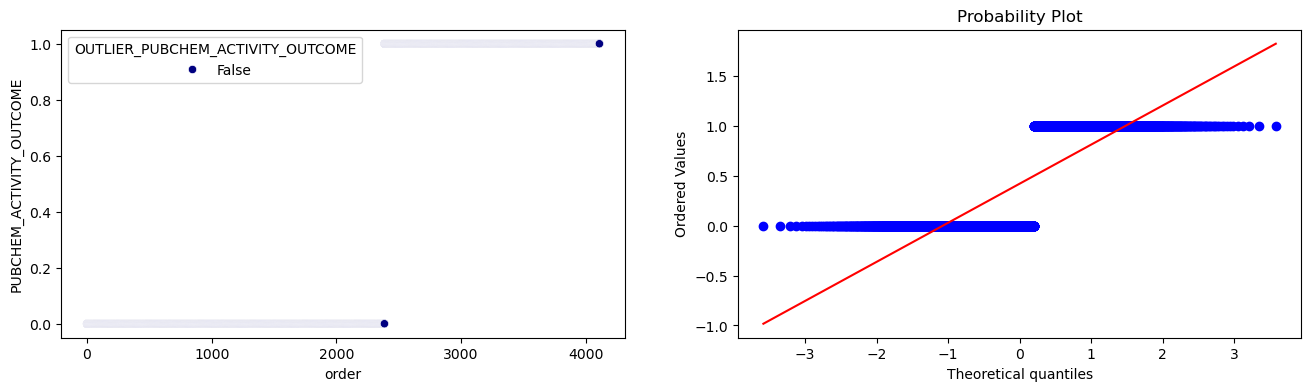

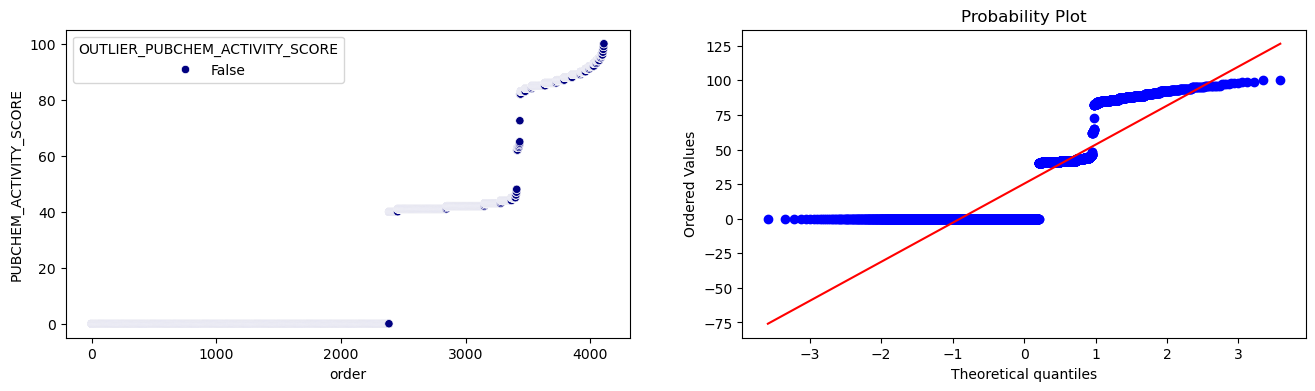

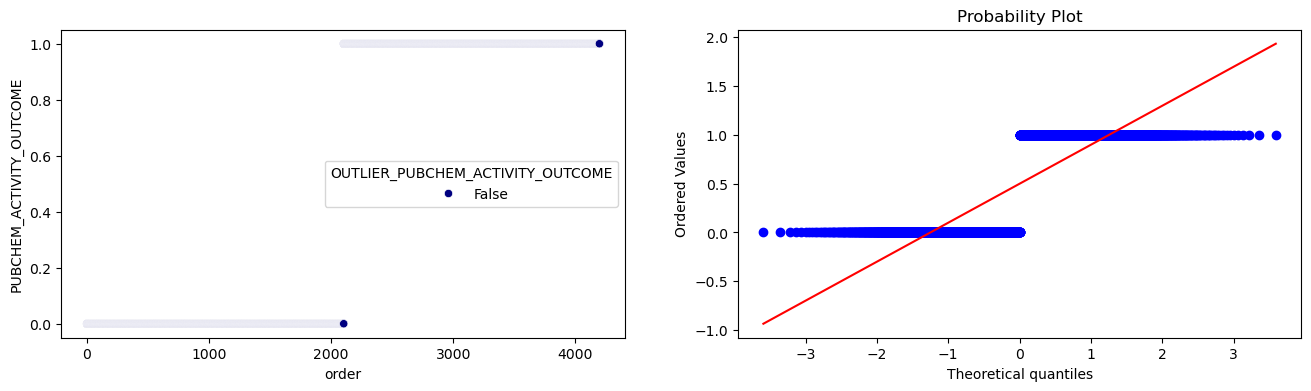

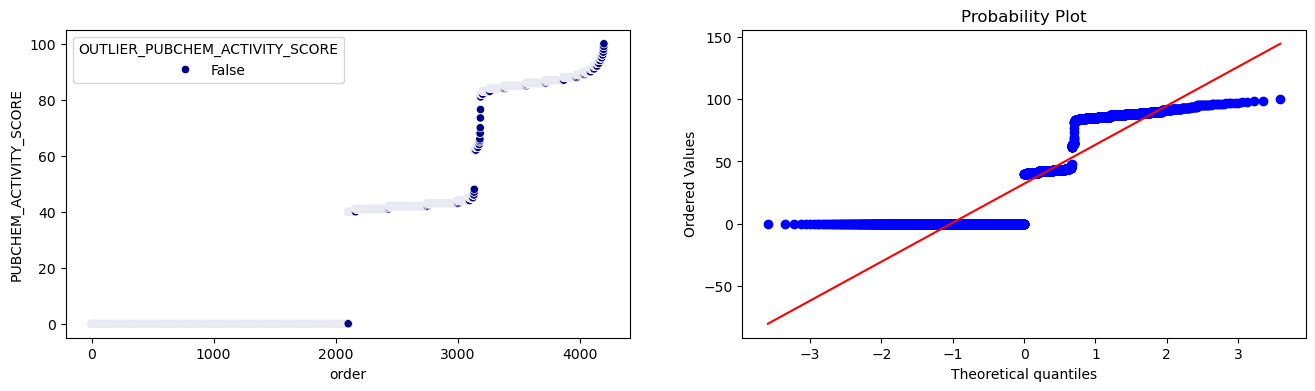

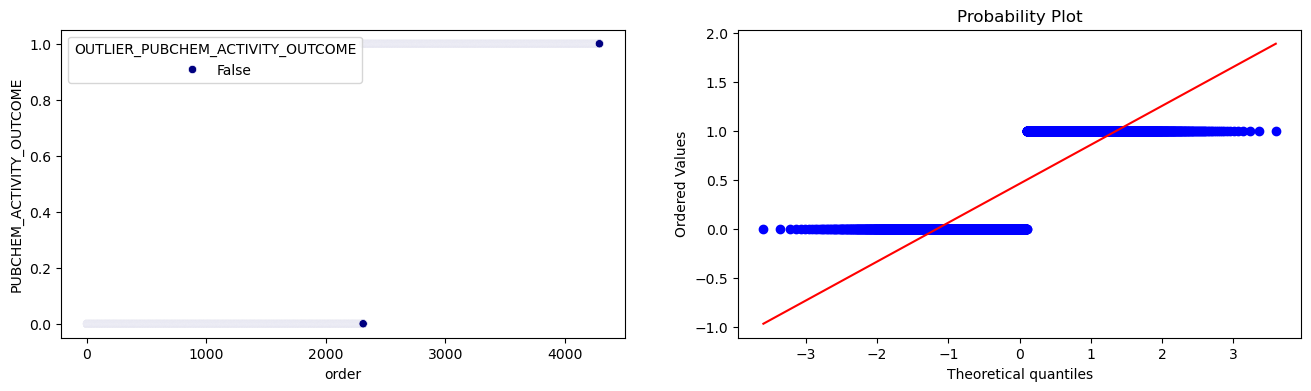

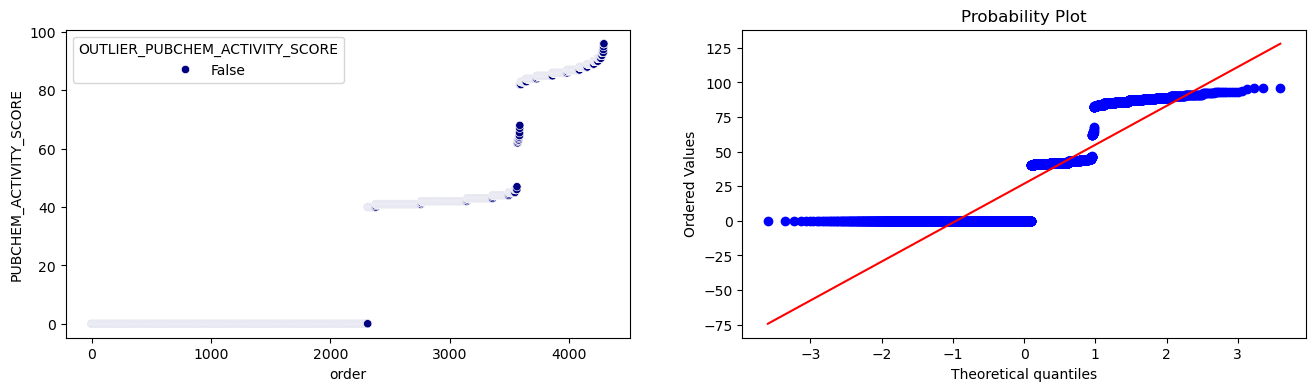

In [6]:
# Look at the distribution of values in each dataset
for ds in range(len(datasets)):
    visualize_distribution(dataset=datasets[ds], data_cols=data_cols)

For each dataset, there is an approximately 50-50 split between active and inactive samples. This is not realistic in a drug discovery program but may still be useful in training models.

### Check activity shift between stereoisomers

In [7]:
for i in range(len(datasets)):
    print(names[i])
    print(datasets[i][[col for col in datasets[i].columns if "stereo_cliff" in col]].sum())

CYP2D6
PUBCHEM_ACTIVITY_OUTCOME_stereo_cliff    0
PUBCHEM_ACTIVITY_SCORE_stereo_cliff      0
dtype: object
CYP3A4
PUBCHEM_ACTIVITY_OUTCOME_stereo_cliff    0
PUBCHEM_ACTIVITY_SCORE_stereo_cliff      0
dtype: object
CYP2C9
PUBCHEM_ACTIVITY_OUTCOME_stereo_cliff    0
PUBCHEM_ACTIVITY_SCORE_stereo_cliff      0
dtype: object


No activity shifts were detected in the datasets.

### Visualize the distribution of active and inactive molecules in chemical space with UMAP

CYP2D6


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<Figure size 640x480 with 0 Axes>

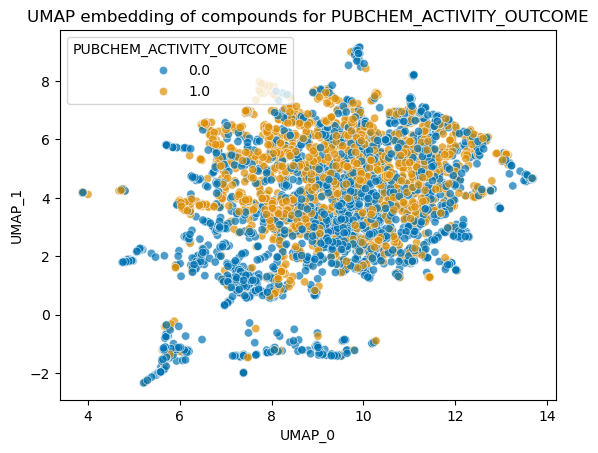

CYP3A4


<Figure size 640x480 with 0 Axes>

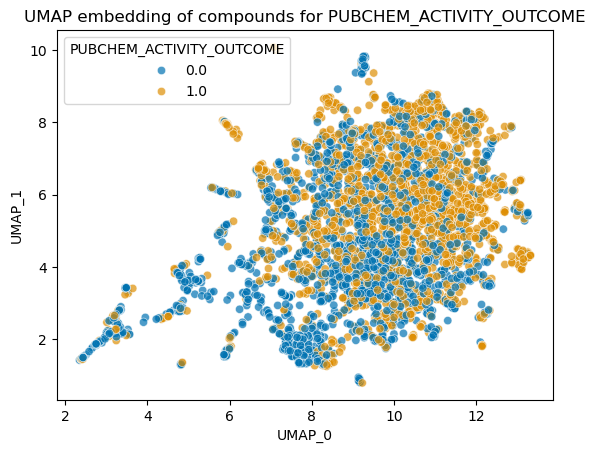

CYP2C9


<Figure size 640x480 with 0 Axes>

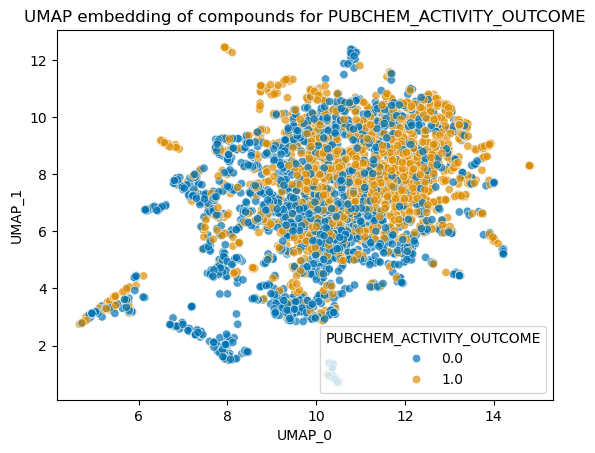

In [8]:
for i in range(len(datasets)):
    print(names[i])
    plt.show(utils.visualize_chemspace(datasets[i], split_names=['PUBCHEM_ACTIVITY_OUTCOME']))

There is no particular structure in UMAP space (with parameters chosen to try to balance local and global structure)

### Preparing dataset annotations for upload

aids = ['AID_1645840', 'AID_1645841', 'AID_1645842']

names = ['CYP2D6', 'CYP3A4', 'CYP2C9']

In [9]:
# Dataset[0] aka 'CYP2D6'

# Additional meta-data on the column level
# The annotations here are the same for all three datasets
annotations = {
    "smiles": ColumnAnnotation(description="Molecule SMILES string", modality="molecule"),

    'PUBCHEM_ACTIVITY_OUTCOME': ColumnAnnotation(description="Binarized label based on the phenotype observed, active antagonism (class = 1) if PUBCHEM_ACTIVITY_SCORE between 40-100, Inactive (class = 0) if 0.",
                                user_attributes={"ref_col": 'PUBCHEM_ACTIVITY_SCORE'}),

    'PUBCHEM_ACTIVITY_SCORE': ColumnAnnotation(description="Average activity score of 5 replicates",
                                ),
}

for i in range(len(datasets)):

    dataset = Dataset(
        # The table is the core data-structure required to construct a dataset
        table=datasets[i],
        # Additional meta-data on the dataset level.
        name=f"ADME_NCATS_{names[i]}",
        description=f"ADME Cytochrome P450 {names[i][-3:]} antagonist experiment data released by the National Center for Advancing Translational Sciences",
        source=sources[i],
        annotations=annotations,
        tags=["ADME"],
        owner=HubOwner(user_id="Shawn Whitfield", slug="swhitfield"),
        license=License(id="MIT"),
        user_attributes={"year": "2021"},
    )

    # Make a temporary directory to save the dataset
    temp_dir = tempfile.TemporaryDirectory().name

    save_dir = dm.fs.join(temp_dir, "dataset")

    path = dataset.to_json(save_dir)

    # Look at the save destination
    fs = dm.fs.get_mapper(save_dir).fs
    fs.ls(save_dir)

    # data_curated.to_parquet(f'./data/{aids[i]}_curated.parquet') # Save just in case. Requires a data folder.

    # NOTE: Commented out to not flood the DB
    # with PolarisHubClient() as client:
    #     client.upload_dataset(dataset=dataset)

Because these data are similar/linked and there is overlap between the molecules from the different datasets, we could also combine the data and upload one dataframe.

In [10]:
to_join = []
for i in range(len(datasets)):
    # Rename the outcome columns to add the cyp name
    to_join.append(datasets[i].rename(columns={'PUBCHEM_ACTIVITY_OUTCOME': f'{names[i]}_PUBCHEM_ACTIVITY_OUTCOME',
                                              'PUBCHEM_ACTIVITY_SCORE': f'{names[i]}_PUBCHEM_ACTIVITY_SCORE'}))

In [11]:
# Join the datasets together
joined_datasets = to_join[0].merge(to_join[1], how='outer').merge(to_join[2], how='outer')
# Drop the duplicates 
joined_datasets.drop_duplicates(subset = 'smiles', ignore_index=True)

,SMILES,CYP2D6_PUBCHEM_ACTIVITY_OUTCOME,CYP2D6_PUBCHEM_ACTIVITY_SCORE,ORIGINAL_PUBCHEM_ACTIVITY_OUTCOME,ORIGINAL_PUBCHEM_ACTIVITY_SCORE,ORIGINAL_SMILES,smiles,molhash_id,molhash_id_no_stereo,num_stereo_center,...,PUBCHEM_ACTIVITY_OUTCOME_zscore,PUBCHEM_ACTIVITY_OUTCOME_stereo_cliff,PUBCHEM_ACTIVITY_SCORE_zscore,PUBCHEM_ACTIVITY_SCORE_stereo_cliff,UMAP_0,UMAP_1,CYP3A4_PUBCHEM_ACTIVITY_OUTCOME,CYP3A4_PUBCHEM_ACTIVITY_SCORE,CYP2C9_PUBCHEM_ACTIVITY_OUTCOME,CYP2C9_PUBCHEM_ACTIVITY_SCORE
0,C1CCNC(=O)C(C1)NC(=O)C2=CC=CC=C2NC(=O)C3=CC4=C...,0.0,0.0,0.0,0.0,C1CCNC(=O)C(C1)NC(=O)C2=CC=CC=C2NC(=O)C3=CC4=C...,O=C(Nc1ccccc1C(=O)NC1CCCCNC1=O)c1cc2ccccc2s1,00125b8af5c9c92c81a62bf60994f7873ea54338,995ae43be4902d39aa863108d7f508c78e120762,1,...,NaN,NaN,NaN,NaN,10.327510,3.770430,NaN,NaN,NaN,NaN
1,COC1=CC2=C(C=CN=C2C=C1OC)OC3=CC=C(C=C3)NC(=O)C...,0.0,0.0,0.0,0.0,COC1=CC2=C(C=CN=C2C=C1OC)OC3=CC=C(C=C3)NC(=O)C...,COc1cc2nccc(Oc3ccc(NC(=O)C4(C(=O)Nc5ccc(F)cc5)...,0012e3e389cd23f4bc372d1b052cea86a1910e0b,4efa33537c56d00cab052dce37ddab49451528d0,0,...,NaN,NaN,NaN,NaN,12.524125,5.664669,NaN,NaN,NaN,NaN
2,CCOCC(COC1=CC=C(C=C1)NC(=O)CC[S+](C)C)O.CC1=CC...,0.0,0.0,0.0,0.0,CCOCC(COC1=CC=C(C=C1)NC(=O)CC[S+](C)C)O.CC1=CC...,CCOCC(O)COc1ccc(NC(=O)CC[S+](C)C)cc1,0021a8f1ff949a318fa9eb634ffd05c5425a38cc,458424d0c02f44463c4d67b468a995bbd784ec6f,1,...,NaN,NaN,NaN,NaN,9.683601,3.063373,NaN,NaN,NaN,NaN
3,CN1CCC(CC1)NC2=NC=C3C(=N2)C(=NC=N3)NC4=CC(=C(C...,1.0,41.0,1.0,41.0,CN1CCC(CC1)NC2=NC=C3C(=N2)C(=NC=N3)NC4=CC(=C(C...,CN1CCC(Nc2ncc3ncnc(Nc4ccc(F)c(Cl)c4)c3n2)CC1,0022caa9c498130e1c28f60b6fc78d31d2ca5798,4c6688c0ccb408ed216dca0766f0bb229a5ef9a5,0,...,inf,NaN,inf,NaN,12.287937,6.112780,NaN,NaN,NaN,NaN
4,CC1=CC(=C(N1)/C=C\2/C3=CC=CC=C3NC2=O)C,0.0,0.0,0.0,0.0,CC1=CC(=C(N1)/C=C\2/C3=CC=CC=C3NC2=O)C,Cc1cc(C)c(/C=C2\C(=O)Nc3ccccc32)[nH]1,006076cca33dd7290a9b81b92d9a1348a8caece0,56a2be02d8f2b447720e4d9a934ff8d78862ee6f,0,...,NaN,NaN,NaN,NaN,7.469997,5.727659,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4990,CNC1=NC(=NC=C1Cl)NC2=C(C=C(C=C2)C(=O)N3CCOCC3)OC,NaN,NaN,0.0,0.0,CNC1=NC(=NC=C1Cl)NC2=C(C=C(C=C2)C(=O)N3CCOCC3)OC,CNc1nc(Nc2ccc(C(=O)N3CCOCC3)cc2OC)ncc1Cl,f4705fe261d6619a594ffdff3fb0ccc296974948,85e02c47dc2732f2f5d51a17cae9886809c2f20c,0,...,NaN,NaN,NaN,NaN,12.366656,10.693689,NaN,NaN,0.0,0.0
4991,CN(C)CCC1=CNC2=C1C(=CC=C2)OP(=O)(O)O,NaN,NaN,0.0,0.0,CN(C)CCC1=CNC2=C1C(=CC=C2)OP(=O)(O)O,CN(C)CCc1c[nH]c2cccc(OP(=O)(O)O)c12,f7cf9507344b105ad47a75be9e5e94360b2c832b,fb4a3d8b717dd03f20736bfd716e7c911da63502,0,...,NaN,NaN,NaN,NaN,7.773678,9.055200,NaN,NaN,0.0,0.0
4992,CC(C(=O)N)NCC1=CC=C(C=C1)OCC2=CC(=CC=C2)F,NaN,NaN,0.0,0.0,CC(C(=O)N)NCC1=CC=C(C=C1)OCC2=CC(=CC=C2)F,CC(NCc1ccc(OCc2cccc(F)c2)cc1)C(N)=O,fa8240be1f2292fed6e70e8e09c822823c02bc40,141aff924ca28f924679e83cc9416acbc15688b6,1,...,NaN,NaN,NaN,NaN,11.295455,8.507569,NaN,NaN,0.0,0.0
4993,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...,NaN,NaN,1.0,43.0,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...,CNC(=O)CN1CCC(Oc2cc3c(Nc4cccc(Cl)c4F)ncnc3cc2O...,fb5c7abee79650e6c7a23abc54150245e658ca28,0365c70a3e0cc03ede2c24e1b7358bea2d931037,0,...,inf,NaN,inf,NaN,13.222765,9.698551,NaN,NaN,1.0,43.0


The advantage of this is the potential for the end user to drop nans and then quickly have molecules that have been tested against each of the three CYP enzymes. The disadvantage is that it would require more preprocessing on the part of the end user before a model can be trained. The metadata addition and upload are left to do.

In [13]:
# Load dataset through json file given
# dataset = load_dataset(path)

In [14]:


# NOTE: Commented out to not flood the DB
# with PolarisHubClient() as client:
#     client.upload_dataset(dataset=dataset)